# Курсовой проект для курса "Python для Data Science"

## Задание

Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:

Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт). Приложить файл с названием по образцу SShirkin_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price). В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний). Сроки и условия сдачи: Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту"). Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6. При сдаче до дедлайна результат проекта может попасть в топ лучших результатов. Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи. Успешный проект нельзя пересдать в целях повышения результата. Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат. В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):

Файл должен содержать заголовки и комментарии Повторяющиеся операции лучше оформлять в виде функций Не делать вывод большого количества строк таблиц (5-10 достаточно) По возможности добавлять графики, описывающие данные (около 3-5) Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний) Весь проект должен быть в одном скрипте (файл ipynb). При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию, но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров. Допускается применение библиотек Python и моделей машинного обучения, которые были в курсе Python для Data Science. Градиентный бустинг изучается в последующих курсах, поэтому в этом проекте его применять не следует. Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import os


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import random
import warnings

from matplotlib import style
from sklearn import ensemble
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, GridSearchCV
from datetime import datetime
from pylab import rcParams

style.use('fivethirtyeight')
%matplotlib inline
warnings.filterwarnings('ignore')

In [55]:
matplotlib.rcParams.update({'font.size': 14})

In [81]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2 :\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2 :\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('predictions values')
    plt.ylabel('True values')
    plt.title('Train sample predictions')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('predictions values')
    plt.ylabel('True values')
    plt.title('Test sample predictions')

    plt.show()

In [57]:
os.getcwd()

'C:\\Users\\mkravchenko\\OneDrive - ООО ЛК ЭВОЛЮЦИЯ\\Рабочий стол\\Библиотеки Python для DS\\Курсовая\\моя\\Course_project_Kravchenko'

In [12]:
ls

 Том в устройстве C имеет метку Windows 
 Серийный номер тома: 3442-DD2D

 Содержимое папки C:\Users\mkravchenko\OneDrive - ООО ЛК ЭВОЛЮЦИЯ\Рабочий стол\Библиотеки Python для DS\Курсовая\моя\Course_project_Kravchenko

13.04.2022  16:50    <DIR>          .
13.04.2022  16:38    <DIR>          ..
13.04.2022  15:58    <DIR>          .ipynb_checkpoints
13.04.2022  16:49             9 224 MKravchenko.ipynb
13.04.2022  13:00           486 139 test.csv
13.04.2022  13:00         1 157 314 train.csv
               3 файлов      1 652 677 байт
               3 папок  12 331 425 792 байт свободно


In [58]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [59]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Описание датасета**

- **Id** - идентификационный номер квартиры
- **DistrictId** - идентификационный номер района
- **Rooms** - количество комнат
- **Square** - площадь
- **LifeSquare** - жилая площадь
- **KitchenSquare** - площадь кухни
- **Floor** - этаж
- **HouseFloor** - количество этажей в доме
- **HouseYear** - год постройки дома
- **Ecology_1**, **Ecology_2**, **Ecology_3** - экологические показатели местности
- **Social_1**, **Social_2**, **Social_3** - социальные показатели местности
- **Healthcare_1**, **Helthcare_2** - показатели местности, связанные с охраной здоровья
- **Shops_1**, **Shops_2** - показатели, связанные с наличием магазинов, торговых центров
- **Price** - цена квартиры

In [60]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


Анализ распределения целевой переменной в разрезе иных признаков

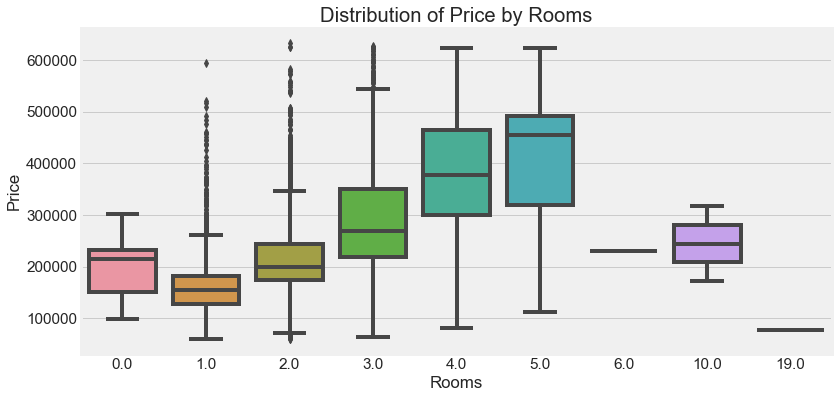

In [61]:
plt.figure(figsize=(12, 6))
sns.boxplot(train_df['Rooms'], train_df['Price'])
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.title('Distribution of Price by Rooms')
plt.show()

Исключение малозначимых столбцов, содержащих количественные признаки

In [62]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>],
       [<AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'Price'}>]], dtype=object)

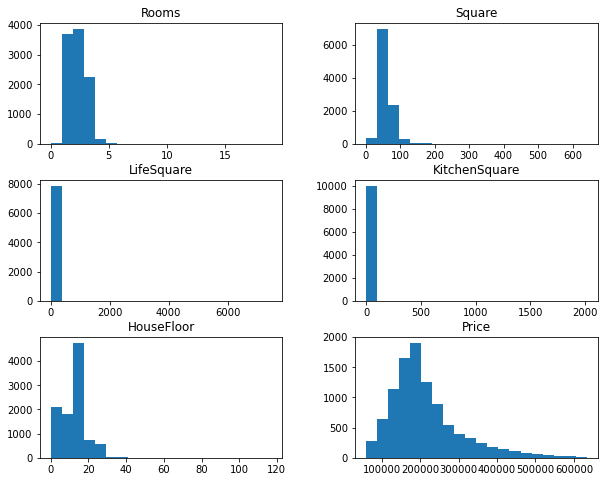

In [20]:
df_num_features = train_df.select_dtypes(include='float64')

num_features = pd.DataFrame(df_num_features)
num_features.drop('Ecology_1', axis=1, inplace=True)
num_features.drop('Healthcare_1', axis=1, inplace=True)
num_features.hist(figsize=(10, 8), bins=20, grid=False)

Взаимосвязь признаков

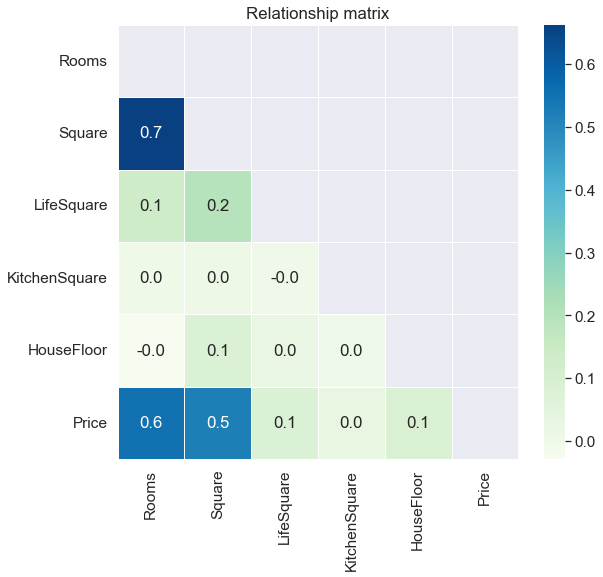

In [63]:
corr = num_features.corr()
plt.figure(figsize = (8, 8))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='GnBu')
plt.title('Relationship matrix')
plt.show()

In [64]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Заполнение пропусков

In [66]:
train_df = train_df.sort_values('Price')
test_df = test_df.sort_values('DistrictId')
train_df = train_df.fillna(method='pad')
test_df = test_df.fillna(method='pad')

Проверка данных

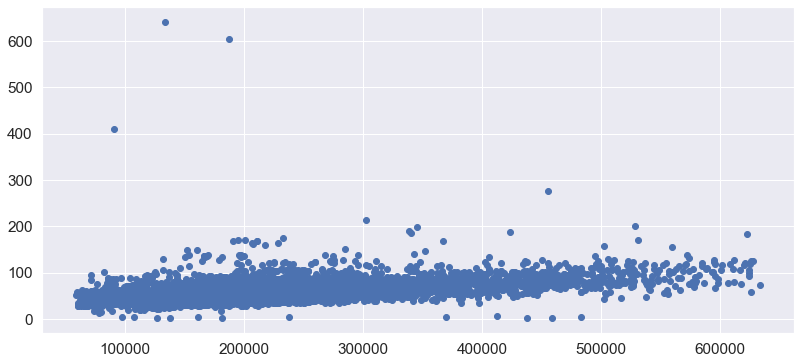

In [67]:
rcParams['figure.figsize'] = 12, 6  # изменение размера графиков

plt.scatter(train_df.Price, train_df.Square)

Формирование и обучение модели. Предсказание цен

In [87]:
# формирование модели

X_train = train_df.drop('Price', axis=1) 
y_train = train_df['Price']

X_test = test_df 

pr = pd.DataFrame()
pr['Id'] = X_test['Id'].copy() 

del_list = ["Id", "DistrictId", "LifeSquare", "Healthcare_1", "Ecology_2", "Ecology_3", "Shops_2"]
X_train.drop(del_list, axis=1, inplace=True) 
X_test.drop(del_list, axis=1, inplace=True)

# обучение модели
model = RandomForestRegressor(n_estimators=1000, max_depth=16, random_state=42, max_features=7)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) 

# предсказание цен
pr['Price'] = y_pred 
pr.to_csv('MKravchenko_predictions.csv', index=False) 

KeyError: 'Id'